In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import map_coordinates
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node
rm -rf "/shared/CSHL_data_processed/MD585/MD585_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropbox.txt" && mkdir -p "/shared/CSHL_data_processed/MD585"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropbox.txt" "/shared/CSHL_data_processed/MD585/MD585_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropbox.txt"
rm -rf "/shared/CSHL_data_processed/MD589/MD589_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropbox.txt" && mkdir -p "/shared/CSHL_data_processed/MD589"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropbox.txt" "/shared/CSHL_data_processed/MD589/MD589_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropbox.txt"
rm -rf "/shared/CSHL_data_processed/MD590/MD590_alignedTo_MD590-N47-2015.09.12-05.32.06_MD590_2_0140_cropbox.txt" && mkdir -p "/shared/CSHL_data_

rm -rf "/shared/CSHL_data_processed/MD589/MD589_prep2_thumbnail/MD589-N16-2015.07.30-17.03.43_MD589_3_0048_prep2_thumbnail.tif" && mkdir -p "/shared/CSHL_data_processed/MD589/MD589_prep2_thumbnail"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_prep2_thumbnail/MD589-N16-2015.07.30-17.03.43_MD589_3_0048_prep2_thumbnail.tif" "/shared/CSHL_data_processed/MD589/MD589_prep2_thumbnail/MD589-N16-2015.07.30-17.03.43_MD589_3_0048_prep2_thumbnail.tif"
rm -rf "/shared/CSHL_data_processed/MD590/MD590_prep2_thumbnail/MD590-IHC17-2015.08.10-19.09.09_MD590_2_0050_prep2_thumbnail.tif" && mkdir -p "/shared/CSHL_data_processed/MD590/MD590_prep2_thumbnail"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD590/MD590_prep2_thumbnail/MD590-IHC17-2015.08.10-19.09.09_MD590_2_0050_prep2_thumbnail.tif" "/shared/CSHL_data_processed/MD590/MD590_prep2_thumbnail/MD590-IHC17-2015.08.10-19.09.09_MD590_2_0050_prep2_thumbnail.tif"
rm -rf "/shared/CSHL_data_processed/MD591/MD591_prep2_thum

rm -rf "/shared/CSHL_data_processed/MD662/MD662_prep2_thumbnail/MD662&661-F35-2017.06.05-17.08.18_MD662_1_0103_prep2_thumbnail.tif" && mkdir -p "/shared/CSHL_data_processed/MD662/MD662_prep2_thumbnail"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_prep2_thumbnail/MD662&661-F35-2017.06.05-17.08.18_MD662_1_0103_prep2_thumbnail.tif" "/shared/CSHL_data_processed/MD662/MD662_prep2_thumbnail/MD662&661-F35-2017.06.05-17.08.18_MD662_1_0103_prep2_thumbnail.tif"


In [2]:
############

model_dir_name = 'inception-bn-blue'
download_from_s3(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name), is_dir=True)
model_name = 'inception-bn-blue'
model_iteration = 0
output_symbol_name = 'flatten_output'
output_dim = 1024
mean_img = np.load(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# Reference on how to predict with mxnet model:
# https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
model0, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, model_name), 0)
flatten_output = model0.get_internals()[output_symbol_name]
# if HOST_ID == 'workstation':
model = mx.mod.Module(context=[mx.gpu(i) for i in range(1)], symbol=flatten_output)
# else:
#     model = mx.mod.Module(context=[mx.gpu(i) for i in range(8)], symbol=flatten_output)

# Increase batch_size to 500 does not save any time.
batch_size = 256
model.bind(data_shapes=[('data', (batch_size,1,224,224))], for_training=False)
model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)

###############

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:52: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [3]:
stack = 'MD661'
section_to_filename = metadata_cache['sections_to_filenames'][stack]

windowing_id = 1

windowing_properties = windowing_settings[windowing_id]
patch_size = windowing_properties['patch_size']
spacing = windowing_properties['spacing']
w, h = metadata_cache['image_shape'][stack]
half_size = patch_size/2

grid_spec = (patch_size, spacing, w, h)

sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

In [5]:
# filenames = [fn for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'F'][83:89]
filenames = [fn for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'F'][118:119]

In [6]:
roi_xmin = 414 * 8
roi_ymin = 1212 * 8
roi_w = 551 * 8
roi_h = 528 * 8

In [13]:
####################

model_name = 'inception-bn-blue'
classifier_id = 38

classifier_properties = classifier_settings.loc[classifier_id]
assert dataset_settings.loc[int(classifier_properties['train_set_id'].split('/')[0])]['network_model'] == model_name
svm_id = int(classifier_properties['svm_id'])

########################

available_classifiers = {svm_id: DataManager.load_classifiers(classifier_id=svm_id)}

rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/sp5_clf_setting_38.dump"


Setting 38: No classifier found for sp5.


rm -rf "/shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" && mkdir -p "/shared/CSHL_classifiers/setting_38/classifiers"
aws s3 cp "s3://mousebrainatlas-data/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump" "/shared/CSHL_classifiers/setting_38/classifiers/outerContour_clf_setting_38.dump"


Setting 38: No classifier found for outerContour.


In [26]:
structures = ['Pn']

In [107]:
scoremap_viz_allSchemes_allFns_allStructs = defaultdict(lambda: defaultdict(dict))

for fn in filenames:

    ####################

    t = time.time()
    mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, fn=fn)
    indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb, bbox_lossless=(roi_xmin,roi_ymin,roi_w,roi_h))
    sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       

    n = len(indices_roi)
    sys.stderr.write('%d samples.\n' % n)

    ############################

    sample_locations_roi = sample_locations[indices_roi]

    ###########################

    t = time.time()
    img_blue = DataManager.load_image_v2(stack=stack, fn=fn, prep_id=2, resol='lossless')[..., 2]
    sys.stderr.write('Read: %.2f seconds\n' % (time.time() - t))
    
    for low in np.arange(500, 1500, 100):
#     for low in [500]:

    #     probs_allFns_allClasses = {}
    #     scoremaps_allFns_allClasses = {}

        high = 0

        t = time.time()
        img_blue_intensity_normalized = rescale_intensity_v2(img_blue, low, high)
        sys.stderr.write('Convert: %.2f seconds\n' % (time.time() - t))

        patches = np.array([img_blue_intensity_normalized[y-half_size:y+half_size, x-half_size:x+half_size]
                            for x, y in sample_locations_roi]) # n x 224 x 224

        #############################

        patches_mean_subtracted = patches - mean_img
        patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

        t1 = time.time()        
        data_iter = mx.io.NDArrayIter(
                        patches_mean_subtracted_input, 
                        batch_size=batch_size,
                        shuffle=False)
        outputs = model.predict(data_iter, always_output_list=True)
        features = outputs[0].asnumpy()

        del data_iter

        sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1))

        #################################

        def clf_predict(stack, fn):

            clf_allClasses_ = available_classifiers[svm_id]
            
            probs_allClasses = {}
#             for structure, clf in clf_allClasses_.iteritems():
            for structure in structures:
                clf = clf_allClasses_[structure]
                probs = clf.predict_proba(features)[:, clf.classes_.tolist().index(1.)]
                probs_allClasses[structure] = probs

            return probs_allClasses

        t = time.time()

        probs_allClasses = clf_predict(stack=stack, fn=fn)
        #         probs_allFns_allClasses[fn] = clf_predict(stack=stack, fn=fn)

        #         pool = Pool(NUM_CORES/2)
        #         probs_allFns_allClasses = dict(zip(filenames, pool.map(lambda fn: clf_predict(stack=stack, fn=fn), filenames)))
        #         pool.close()
        #         pool.join()

        sys.stderr.write('Classifier predict: %.2f\n' % (time.time()-t))
        
        #############################

        downscale = 32

        ##############################

        def resample(fn):

#             try:
#                 _, sample_locations_roi = DataManager.load_patch_locations(stack=stack, fn=fn, win=windowing_id)
#             except Exception as e:
#                 sys.stderr.write('Error loading patch locations for %s: %s.\n' % (fn, str(e)))
#                 return

            downscaled_grid_y = np.arange(0, h, downscale)
            downscaled_grid_x = np.arange(0, w, downscale)
            downscaled_ny = len(downscaled_grid_y)
            downscaled_nx = len(downscaled_grid_x)

            scoremaps_allClasses = {}

#             for structure in all_structures_with_classifiers:
            for structure in structures:

#                 sparse_scores = probs_allFns_allClasses[fn][structure]
                sparse_scores = probs_allClasses[structure] 

                f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
                a = (sample_locations_roi - half_size)/spacing
                f_grid[a[:,1], a[:,0]] = sparse_scores

                yinterps = (downscaled_grid_y - half_size)/float(spacing)
                xinterps = (downscaled_grid_x - half_size)/float(spacing)

                points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
                coord = np.c_[points_y.flat, points_x.flat]
                f_interp = map_coordinates(f_grid, coord.T, order=1)
                f_interp_2d = f_interp.reshape((downscaled_ny, downscaled_nx))
                scoremap = f_interp_2d.astype(np.float16)

                scoremaps_allClasses[structure] = scoremap
            return scoremaps_allClasses

        t = time.time()
        scoremaps_allClasses = resample(fn)
#         scoremaps_allFns_allClasses[fn] = resample(fn)

#         pool = Pool(NUM_CORES/2)
#         # pool = Pool(1)
#         scoremaps_allFns_allClasses = dict(zip(filenames, pool.map(resample, filenames)))
#         pool.close()
#         pool.join()

        sys.stderr.write('Resample: %.2f seconds\n' % (time.time() - t)) 

        ###########################

        add_label_text = True
        cmap_name = 'jet'
#         downscale = 8
#         structure = '7N'

        #########################
        
        def save_scoremap(structure):

            if add_label_text:
                label_text = str(structure)
            else:
                label_text = None
            scoremap_viz = scoremap_overlay_on(bg=img_blue_intensity_normalized[roi_ymin:(roi_ymin+roi_h),
                                                                   roi_xmin:(roi_xmin+roi_w)], 
                                               in_downscale=1, stack=stack, fn=fn, structure=structure,
    #                                       scoremap=scoremaps_allFns_allClasses[fn][structure],
#                                               scoremap=rescale(scoremaps_allClasses[structure], 4)[roi_ymin/8:(roi_ymin+roi_h)/8,
#                                                                    roi_xmin/8:(roi_xmin+roi_w)/8],
                                               scoremap=scoremaps_allClasses[structure][roi_ymin/32:(roi_ymin+roi_h)/32,
                                                                   roi_xmin/32:(roi_xmin+roi_w)/32],
                                              in_scoremap_downscale=32,
                                              out_downscale=8, label_text=label_text, 
                                              cmap_name=cmap_name)
            return scoremap_viz

#         pool = Pool(NUM_CORES)
#         structures = scoremaps_allClasses.keys()
#         scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn] = dict(zip(structures, pool.map(save_scoremap, structures)))
#         pool.close()
#         pool.join()
        
        t = time.time()
    
        for s in structures:
            scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn][s] = save_scoremap(s)
            
        sys.stderr.write('Visualize: %.2f seconds\n' % (time.time() - t)) 

locate patches: 0.03 seconds
4553 samples.
Read: 22.87 seconds
Convert: 9.35 seconds
predict: 14.38 seconds
Classifier predict: 0.01
Resample: 0.04 seconds
Visualize: 0.27 seconds
Convert: 9.37 seconds
predict: 14.44 seconds
Classifier predict: 0.01
Resample: 0.04 seconds
Visualize: 0.27 seconds
Convert: 9.30 seconds
predict: 14.36 seconds
Classifier predict: 0.01
Resample: 0.04 seconds
Visualize: 0.27 seconds
Convert: 9.31 seconds
predict: 14.50 seconds
Classifier predict: 0.01
Resample: 0.04 seconds
Visualize: 0.25 seconds
Convert: 9.32 seconds
predict: 14.44 seconds
Classifier predict: 0.01
Resample: 0.04 seconds
Visualize: 0.25 seconds
Convert: 9.32 seconds
predict: 14.55 seconds
Classifier predict: 0.01
Resample: 0.05 seconds
Visualize: 0.25 seconds
Convert: 9.33 seconds
predict: 14.48 seconds
Classifier predict: 0.01
Resample: 0.04 seconds
Visualize: 0.25 seconds
Convert: 9.29 seconds
predict: 14.63 seconds
Classifier predict: 0.01
Resample: 0.04 seconds
Visualize: 0.25 seconds
C

In [108]:
title_viz_tuples = [("%d,%d" % (lo,hi), vizs['Pn'])
 for (lo, hi), x in sorted(scoremap_viz_allSchemes_allFns_allStructs.items())
 for fn, vizs in x.iteritems()]

In [109]:
titles, vizs = zip(*title_viz_tuples)

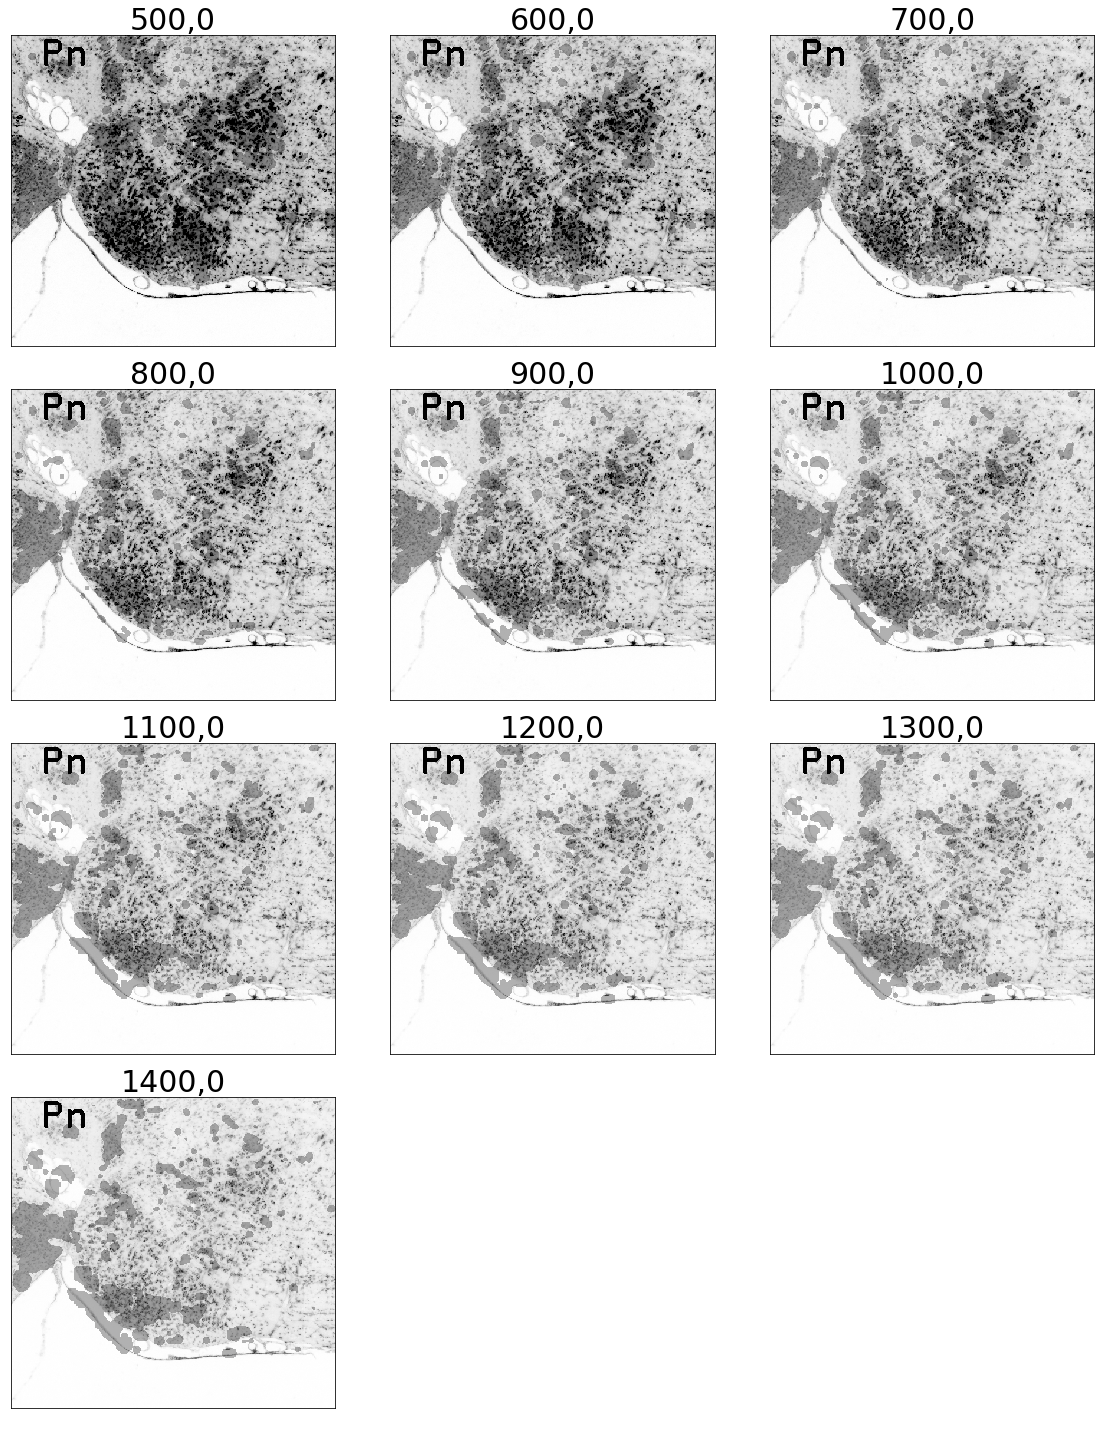

In [110]:
display_images_in_grids(vizs=vizs, titles=titles, nc=3)

In [ ]:
for t, v in zip(titles, vizs):
    plt.figure(figsize=(20,20))
    plt.imshow(v)
    plt.title(t)
    plt.show();